<a href="https://colab.research.google.com/github/mmillet88/russian_therapy/blob/main/pre_processingResponseDataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Loading libraries

In [ ]:
!pip install transformers sentencepiece datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.7 MB 5.3 MB/s 
     |████████████████████████████████| 1.3 MB 62.8 MB/s 
     |████████████████████████████████| 365 kB 73.0 MB/s 
     |████████████████████████████████| 120 kB 67.3 MB/s 
     |████████████████████████████████| 6.6 MB 47.5 MB/s 
     |████████████████████████████████| 115 kB 59.0 MB/s 
     |████████████████████████████████| 212 kB 56.4 MB/s 
     |████████████████████████████████| 127 kB 62.3 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


In [ ]:
import os
import pandas as pd 
import matplotlib.pyplot as plt

from transformers import AutoModel, AutoModelForSequenceClassification, Trainer, TrainingArguments, pipeline
from transformers import BertForSequenceClassification, AutoTokenizer
from transformers import EarlyStoppingCallback
from transformers import (
    glue_tasks_num_labels,
    AutoConfig,
    AutoModelForSequenceClassification,
    AutoTokenizer,
    Trainer,
    GlueDataset,
    GlueDataTrainingArguments,
    TrainingArguments,
)
import torch
import torch.nn as nn
from torch.nn.functional import cross_entropy
import gc

import datasets
from datasets import load_dataset
from datasets import DatasetDict

import numpy as np
from numpy.lib.function_base import average

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

In [ ]:
!pip install -U sentence-transformers
from sentence_transformers import SentenceTransformer, util

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 85 kB 3.2 MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125938 sha256=19509a4654ce1e96c33d5ea2c243f6541bd93ddb3799054e55efc1483e224013
  Stored in directory: /root/.cache/pip/wheels/bf/06/fb/d59c1e5bd1dac7f6cf61ec0036cc3a10ab8fecaa6b2c3d3ee9
Successfully built sentence-transformers


# Downloading a dataset

In [ ]:
import os
!mkdir /content/emp_chatbot
!mkdir emp_chatbot/data

In [ ]:
!ls

drive  emp_chatbot  sample_data


In [ ]:
os.chdir('/content/emp_chatbot/data')

In [ ]:
# https://drive.google.com/file/d/121M9d19m7ljXaw0f5pggpHd9gsN2Hu3U/view?usp=sharing
# !gdown --id 1GaaG8UYKIHWSXR1X3OuxEfBpD2i-3qar
!gdown --id 1uRPD0QPf-I90CopU9eccvzuqxSfsLcPp
# https://drive.google.com/file/d/1GaaG8UYKIHWSXR1X3OuxEfBpD2i-3qar/view?usp=sharing
# !gdown --id 1UhqyvObGgMl3_jEIkDiYJQEkQ7rFOXOc

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1uRPD0QPf-I90CopU9eccvzuqxSfsLcPp
To: /content/emp_chatbot/data/all_emotions_responses.json
100% 1.25M/1.25M [00:00<00:00, 176MB/s]


In [ ]:
# data_files_EPru = {"train": "sadness_questions_follow_up.json"}
data_files_EPru = {"train": "all_emotions_responses.json"}
epru = load_dataset('json', data_files=data_files_EPru)

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

0 tables [00:00, ? tables/s]

Dataset json downloaded and prepared to /root/.cache/huggingface/datasets/json/default-a08d0da97d9d5670/0.0.0/a3e658c4731e59120d44081ac10bf85dc7e1388126b92338344ce9661907f253. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
text = epru['train']["Was this emotion triggered by a specific event?"][0]
print(text)

Я очень сопереживаю вам сейчас. Скажите, ваша тревога вызвана каким-то конкретным событием в вашей жизни?


# Pre-computing Fluency and Embeddings




## Fluency/perplexity

In [ ]:
from transformers import GPT2LMHeadModel, GPT2TokenizerFast, AutoModelWithLMHead, AutoTokenizer

device = "cuda"
# model_id = "sberbank-ai/ruT5-base"
model_id = "sberbank-ai/rugpt3large_based_on_gpt2"
# model = GPT2LMHeadModel.from_pretrained(model_id).to(device)
model_LM = AutoModelWithLMHead.from_pretrained(model_id).to(device)
tokenizer = AutoTokenizer.from_pretrained(model_id)

/usr/local/lib/python3.7/dist-packages/transformers/models/auto/modeling_auto.py:1002: FutureWarning: The class `AutoModelWithLMHead` is deprecated and will be removed in a future version. Please use `AutoModelForCausalLM` for causal language models, `AutoModelForMaskedLM` for masked language models and `AutoModelForSeq2SeqLM` for encoder-decoder models.
  FutureWarning,


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
columns = epru['train'].column_names
print(columns)

['gender', 'age', 'emotion', 'How are you feeling?', 'Was this emotion triggered by a specific event?', 'Was the event recent?', 'Did you find protocol 6 distressing?', 'Did you find protocol 11 distressing?', 'Is it ok to ask additional questions?', 'Have you strongly felt or expressed any of the following emotions towards someone?', 'Do you believe you should be the savior of someone else?', 'Do you feel that you are trying to control someone?', 'Do you see yourself as the victim, blaming someone else for how negative you feel?', 'Are you always blaming and accusing yourself for when something goes wrong?', 'Is it possible that in previous conversations you may not have always considerdother viewpoints presented?', 'Are you undergoing a personal crisis (experience difficulties with loved ones e.g. falling out with friends)?', 'Would you like to attempt protocols for joy?']


In [ ]:
columns = epru['train'].column_names
columns_indices = list(range(4,len(columns)))
perplexity_columns = [columns[index] for index in columns_indices]

In [ ]:
columns_indices = list(range(4,len(columns)))


In [ ]:
columns_indices

[4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]

In [ ]:
perplexity_columns

['Was this emotion triggered by a specific event?',
 'Was the event recent?',
 'Did you find protocol 6 distressing?',
 'Did you find protocol 11 distressing?',
 'Is it ok to ask additional questions?',
 'Have you strongly felt or expressed any of the following emotions towards someone?',
 'Do you believe you should be the savior of someone else?',
 'Do you feel that you are trying to control someone?',
 'Do you see yourself as the victim, blaming someone else for how negative you feel?',
 'Are you always blaming and accusing yourself for when something goes wrong?',
 'Is it possible that in previous conversations you may not have always considerdother viewpoints presented?',
 'Are you undergoing a personal crisis (experience difficulties with loved ones e.g. falling out with friends)?',
 'Would you like to attempt protocols for joy?']

In [ ]:
def calculate_perplexity(row, column_name):
  if len(row[column_name]) != 0:
    encodings = tokenizer(row[column_name], return_tensors="pt")
    input_ids = encodings.input_ids.to(device)
    target_ids = input_ids.clone()
    with torch.no_grad():
      outputs = model_LM(input_ids, labels=target_ids)
      neg_log_likelihood = outputs[0]
    string_name = f"ppl_{column_name}"
    ppl = torch.exp(neg_log_likelihood)
    return {f'ppl_{column_name}': 1/ppl.item()}
  else:
    return {f'ppl_{column_name}': 0}

In [ ]:
for column_name in perplexity_columns:
  epru = epru.map(lambda x: calculate_perplexity(x, column_name))

  0%|          | 0/201 [00:00<?, ?ex/s]

  0%|          | 0/201 [00:00<?, ?ex/s]

  0%|          | 0/201 [00:00<?, ?ex/s]

  0%|          | 0/201 [00:00<?, ?ex/s]

  0%|          | 0/201 [00:00<?, ?ex/s]

  0%|          | 0/201 [00:00<?, ?ex/s]

  0%|          | 0/201 [00:00<?, ?ex/s]

  0%|          | 0/201 [00:00<?, ?ex/s]

  0%|          | 0/201 [00:00<?, ?ex/s]

  0%|          | 0/201 [00:00<?, ?ex/s]

  0%|          | 0/201 [00:00<?, ?ex/s]

  0%|          | 0/201 [00:00<?, ?ex/s]

  0%|          | 0/201 [00:00<?, ?ex/s]

In [ ]:
# emotions = ['fear', 'sadness', 'anger', 'joy']
# mean_dict = dict()
# for emotion in emotions:
#   if emotion != "joy":
#     ds = epru.filter(lambda row: row['emotion']==emotion)
#     mean = 0
#     for column_name in perplexity_columns[:-1]:
#       ds.set_format(type="pandas")
#       df = ds['train'][:]
#       column_name = "ppl_"+column_name
#       df = df.replace(0, np.NaN)
#       mean += df[df[column_name] != 0][column_name].mean()
    
#     mean = mean/12
#     mean_dict[emotion] = mean
#   else:
#     ds = epru.filter(lambda row: row['emotion']==emotion)
#     mean = 0
#     ds.set_format(type="pandas")
#     df = ds['train'][:]
#     column_name = "ppl_"+perplexity_columns[-1]
#     df = df.replace(0, np.NaN)
#     mean += df[df[column_name] != 0][column_name].mean()

#     mean_dict[emotion] = mean

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [ ]:
# mean_dict

{'fear': 0.036122524997140186,
 'sadness': 0.03579624878867541,
 'anger': 0.0357875121069479,
 'joy': 0.02787866903132181}

In [ ]:
# change dataset into pandas 
epru.set_format(type="pandas")
df = epru['train'][:]
df.head()
# emotions = set(df['emotion'].tolist())

,gender,age,emotion,How are you feeling?,Was this emotion triggered by a specific event?,Was the event recent?,Did you find protocol 6 distressing?,Did you find protocol 11 distressing?,Is it ok to ask additional questions?,Have you strongly felt or expressed any of the following emotions towards someone?,...,ppl_Did you find protocol 11 distressing?,ppl_Is it ok to ask additional questions?,ppl_Have you strongly felt or expressed any of the following emotions towards someone?,ppl_Do you believe you should be the savior of someone else?,ppl_Do you feel that you are trying to control someone?,"ppl_Do you see yourself as the victim, blaming someone else for how negative you feel?",ppl_Are you always blaming and accusing yourself for when something goes wrong?,ppl_Is it possible that in previous conversations you may not have always considerdother viewpoints presented?,ppl_Are you undergoing a personal crisis (experience difficulties with loved ones e.g. falling out with friends)?,ppl_Would you like to attempt protocols for joy?
0,male,30-39,fear,Чувство набегающей тревоги.,"Я очень сопереживаю вам сейчас. Скажите, ваша ...",Это событие произошло не так давно?,"Скажите, Методика 6 по ощущениям вам была непр...","Скажите, Методика одиннадцать по ощущениям вам...","Для успешной работы с вами, мне хотелось бы за...",Как вы считаете испытываете ли вы к кому нибу...,...,0.006557,0.040851,0.014102,0.027146,0.017156,0.023888,0.048183,0.032365,0.020980,0.0
1,male,30-39,fear,В последние дни испытываю стресс. Это связано ...,"Спасибо, что уточнили ваше ощущение. Ваша трев...",Это неприятное событие произошло недавно?,"Скажите, пожалуйста, вызвала ли внутренний дис...","Скажите, пожалуйса, вызвала ли внутренний диск...",Мне нужно лучше узнать ситуацию. Вы не возража...,"Вопрос сложный, и отвечать на него обычно труд...",...,0.001624,0.103977,0.034055,0.038575,0.060280,0.043151,0.023524,0.021725,0.041644,0.0
2,male,25-29,fear,Чувствую себя не очень хорошо. Те ситуации и в...,"Как вы считаете, ваши ощущения, мысли, чувства...",Оно произошло недавно?,"Поделитесь со мной, 6 методика вызвала у вас п...","Поделитесь со мной, одиннадцать методика вызва...",Мне бы хотелось задать вам несколько уточняющи...,Сейчас я вынужден задать такой вопрос. Для мно...,...,0.001206,0.067480,0.038050,0.012228,0.050582,0.056604,0.088466,0.041727,0.066578,0.0
3,male,25-29,fear,"Я переживаю из-за того, что мне кажется будто ...",Ваша тревога связана с каким-то конкретным соб...,Вы прошли через этот опыт относительно недавно?,"Спасибо, что открыты со мной. Методика 6 вызва...","Спасибо, что открыты со мной. Методика одиннад...","Чтобы прояснить ситуацию, мне бы хотелось зада...","Это трудный вопрос, я понимаю. вы чувствовали ...",...,0.001351,0.066276,0.021542,0.047179,0.052812,0.039781,0.066156,0.014396,0.017142,0.0
4,male,18-24,fear,"Я не могу спать , в голове полно мыслей ,котор...","Задумайтесь, что могло повлиять на ваше чувств...","Правильно полагать, что это случилось недавно?",Я вам буду благодарен если вы ответите мне - М...,Я вам буду благодарен если вы ответите мне - М...,"Вынужден задать вам несколько вопросов, чтобы ...",Испытываете ли к кому-нибудь негативные чувств...,...,0.007527,0.029090,0.023125,0.017290,0.046658,0.018952,0.125885,0.080967,0.021194,0.0


/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


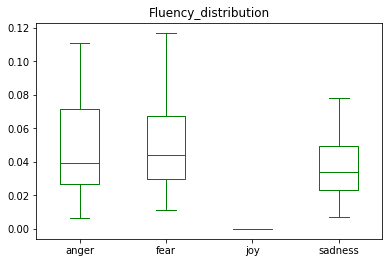

In [ ]:
df['Fluency_distribution'] = df['ppl_Is it ok to ask additional questions?']
df.boxplot('Fluency_distribution', by='emotion', grid=False, showfliers=False, color='green')
plt.suptitle('')
plt.xlabel('')
plt.show()

In [ ]:
df[df['emotion']=='fear']['ppl_Did you find protocol 6 distressing?'].max()

0.03638606673925077

In [ ]:
len(df.emotion.unique())
max_ppl = dict()
for emotion_type in df.emotion.unique():
  max_ppl.setdefault(emotion_type,[])
  for column in perplexity_columns:
    val = df[df['emotion']==emotion_type][f"ppl_{column}"].max()
    lst = max_ppl.get(emotion_type)
    lst.append(val)
    max_ppl[emotion_type] = lst

In [ ]:
max_ppl['sadness']


[0.08522911355303972,
 0.07461860983472446,
 0.03059628344980379,
 0.034103477248791376,
 0.16412582255551444,
 0.16328877282237073,
 0.15492591391722652,
 0.11378260514307845,
 0.0912304763747593,
 0.12356467378815822,
 0.12664713893627497,
 0.05957726107869242,
 0.0]

In [ ]:
def normalise_ppl(row, column, largest_ppl):
  row[column] = row[column]/largest_ppl
  return row


In [ ]:
perplexity_columns

['Was this emotion triggered by a specific event?',
 'Was the event recent?',
 'Did you find protocol 6 distressing?',
 'Did you find protocol 11 distressing?',
 'Is it ok to ask additional questions?',
 'Have you strongly felt or expressed any of the following emotions towards someone?',
 'Do you believe you should be the savior of someone else?',
 'Do you feel that you are trying to control someone?',
 'Do you see yourself as the victim, blaming someone else for how negative you feel?',
 'Are you always blaming and accusing yourself for when something goes wrong?',
 'Is it possible that in previous conversations you may not have always considerdother viewpoints presented?',
 'Are you undergoing a personal crisis (experience difficulties with loved ones e.g. falling out with friends)?',
 'Would you like to attempt protocols for joy?']

In [ ]:
epru.reset_format()

In [ ]:
normalised_epru = epru
for index, column in enumerate(perplexity_columns):
  normalised_epru = normalised_epru.map(lambda x: normalise_ppl(x, f"ppl_{column}", largest_ppl= max_ppl[x['emotion']][index]))

  0%|          | 0/201 [00:00<?, ?ex/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in double_scalars
  


  0%|          | 0/201 [00:00<?, ?ex/s]

  0%|          | 0/201 [00:00<?, ?ex/s]

  0%|          | 0/201 [00:00<?, ?ex/s]

  0%|          | 0/201 [00:00<?, ?ex/s]

  0%|          | 0/201 [00:00<?, ?ex/s]

  0%|          | 0/201 [00:00<?, ?ex/s]

  0%|          | 0/201 [00:00<?, ?ex/s]

  0%|          | 0/201 [00:00<?, ?ex/s]

  0%|          | 0/201 [00:00<?, ?ex/s]

  0%|          | 0/201 [00:00<?, ?ex/s]

  0%|          | 0/201 [00:00<?, ?ex/s]

  0%|          | 0/201 [00:00<?, ?ex/s]

In [ ]:
# epru[train]["ppl_Did you find protocol 6 distressing?"]
normalised_epru['train']["ppl_Have you strongly felt or expressed any of the following emotions towards someone?"]

[0.11785986874778899,
 0.28461541709252314,
 0.3180067513406193,
 0.18003530544709206,
 0.193272041303532,
 0.2973856513006793,
 0.8969955289232056,
 0.5319078736132467,
 0.5016617948162534,
 0.12629928743119198,
 0.3432825215337896,
 0.6494295420433271,
 0.20946166808083463,
 0.3424942755184471,
 0.3422620386652019,
 0.25653512271328666,
 0.4105451669569765,
 0.49218352825838524,
 0.41944529559783467,
 0.3826818464981332,
 0.22042642118259906,
 0.023729202496917755,
 0.11935491409993561,
 0.11195544063183022,
 0.025881957302063184,
 0.21228242628364133,
 0.3140427935151437,
 0.24608584882856832,
 0.2016150717329088,
 0.17647656079208507,
 0.4249326929995871,
 0.12653365472524306,
 0.08989023980353303,
 0.18953164657597127,
 1.0,
 0.7772171751231246,
 0.4193846357047966,
 0.3088907820536906,
 0.6248008276529392,
 0.17034796574458533,
 0.5215928446550547,
 0.27146133976150233,
 0.23160214323558972,
 0.8021682325320373,
 0.35693885279723464,
 0.5184975740508221,
 0.06668688071090123,
 0.

## Empathy

In [ ]:
# model_id = "mmillet/distilrubert-tiny-cased-conversational-v1_single_finetuned_empathy_classifier"
model_id = "mmillet/distilrubert-tiny-cased-conversational-v1_empathy_preprocessed_punct_lowercasing"
classifier = pipeline('text-classification', model=model_id)

In [ ]:
preds = classifier(epru['train'][8]["Have you strongly felt or expressed any of the following emotions towards someone?"], top_k=3)
preds = classifier("Это очень хорошо, что вы открыты, очень постараюсь вам помочь. Уверен, что у нас все получится. Задам вам дополнительные вопросы.", top_k=3)
print(preds)
prediction = max(preds, key=lambda x: x['score'])
print(prediction)

[{'label': 'LABEL_0', 'score': 0.8899251222610474}, {'label': 'LABEL_2', 'score': 0.09661342203617096}, {'label': 'LABEL_1', 'score': 0.013461414724588394}]
{'label': 'LABEL_0', 'score': 0.8899251222610474}


In [ ]:
epru['train'][8]["Have you strongly felt or expressed any of the following emotions towards someone?"]

'Я думаю это непростой вопрос, но все же попытайтесь ответить максимально честно. Скажите, вы когда-либо испытывали такие чувства, как зависть, ненависть, злость?'

In [ ]:
def calculate_empathy(row, column_name):
  if len(row[column_name]) != 0:
    # print(type(row[column_name]))
    preds = classifier(row[column_name], top_k=3)
    prediction = max(preds, key=lambda x: x['score'])
    if prediction["label"] == 'LABEL_0':
      score = 1
    elif prediction["label"] == 'LABEL_1':
      score = 0.33
    else:
      score = 0.67
    return {f'emp_{column_name}': score}
  else:
    return {f'emp_{column_name}': 0}

In [ ]:
for column_name in perplexity_columns:
  normalised_epru = normalised_epru.map(lambda x: calculate_empathy(x, column_name))

  0%|          | 0/201 [00:00<?, ?ex/s]

  0%|          | 0/201 [00:00<?, ?ex/s]

  0%|          | 0/201 [00:00<?, ?ex/s]

  0%|          | 0/201 [00:00<?, ?ex/s]

  0%|          | 0/201 [00:00<?, ?ex/s]

  0%|          | 0/201 [00:00<?, ?ex/s]

  0%|          | 0/201 [00:00<?, ?ex/s]

  0%|          | 0/201 [00:00<?, ?ex/s]

  0%|          | 0/201 [00:00<?, ?ex/s]

  0%|          | 0/201 [00:00<?, ?ex/s]

  0%|          | 0/201 [00:00<?, ?ex/s]

  0%|          | 0/201 [00:00<?, ?ex/s]

  0%|          | 0/201 [00:00<?, ?ex/s]

In [ ]:
# change dataset into pandas 
normalised_epru.set_format(type="pandas")
df = normalised_epru['train'][:]
# df["emp_Have you strongly felt or expressed any of the following emotions towards someone?"]
df.head()

,gender,age,emotion,How are you feeling?,Was this emotion triggered by a specific event?,Was the event recent?,Did you find protocol 6 distressing?,Did you find protocol 11 distressing?,Is it ok to ask additional questions?,Have you strongly felt or expressed any of the following emotions towards someone?,...,emp_Did you find protocol 11 distressing?,emp_Is it ok to ask additional questions?,emp_Have you strongly felt or expressed any of the following emotions towards someone?,emp_Do you believe you should be the savior of someone else?,emp_Do you feel that you are trying to control someone?,"emp_Do you see yourself as the victim, blaming someone else for how negative you feel?",emp_Are you always blaming and accusing yourself for when something goes wrong?,emp_Is it possible that in previous conversations you may not have always considerdother viewpoints presented?,emp_Are you undergoing a personal crisis (experience difficulties with loved ones e.g. falling out with friends)?,emp_Would you like to attempt protocols for joy?
0,male,30-39,fear,Чувство набегающей тревоги.,"Я очень сопереживаю вам сейчас. Скажите, ваша ...",Это событие произошло не так давно?,"Скажите, Методика 6 по ощущениям вам была непр...","Скажите, Методика одиннадцать по ощущениям вам...","Для успешной работы с вами, мне хотелось бы за...",Как вы считаете испытываете ли вы к кому нибу...,...,1.00,1.00,0.33,1.00,1.00,0.33,0.33,1.00,0.67,0
1,male,30-39,fear,В последние дни испытываю стресс. Это связано ...,"Спасибо, что уточнили ваше ощущение. Ваша трев...",Это неприятное событие произошло недавно?,"Скажите, пожалуйста, вызвала ли внутренний дис...","Скажите, пожалуйса, вызвала ли внутренний диск...",Мне нужно лучше узнать ситуацию. Вы не возража...,"Вопрос сложный, и отвечать на него обычно труд...",...,0.67,1.00,1.00,1.00,0.33,0.33,0.67,1.00,0.67,0
2,male,25-29,fear,Чувствую себя не очень хорошо. Те ситуации и в...,"Как вы считаете, ваши ощущения, мысли, чувства...",Оно произошло недавно?,"Поделитесь со мной, 6 методика вызвала у вас п...","Поделитесь со мной, одиннадцать методика вызва...",Мне бы хотелось задать вам несколько уточняющи...,Сейчас я вынужден задать такой вопрос. Для мно...,...,0.33,1.00,1.00,0.67,1.00,1.00,0.33,0.33,1.00,0
3,male,25-29,fear,"Я переживаю из-за того, что мне кажется будто ...",Ваша тревога связана с каким-то конкретным соб...,Вы прошли через этот опыт относительно недавно?,"Спасибо, что открыты со мной. Методика 6 вызва...","Спасибо, что открыты со мной. Методика одиннад...","Чтобы прояснить ситуацию, мне бы хотелось зада...","Это трудный вопрос, я понимаю. вы чувствовали ...",...,1.00,1.00,1.00,1.00,0.33,1.00,0.33,1.00,1.00,0
4,male,18-24,fear,"Я не могу спать , в голове полно мыслей ,котор...","Задумайтесь, что могло повлиять на ваше чувств...","Правильно полагать, что это случилось недавно?",Я вам буду благодарен если вы ответите мне - М...,Я вам буду благодарен если вы ответите мне - М...,"Вынужден задать вам несколько вопросов, чтобы ...",Испытываете ли к кому-нибудь негативные чувств...,...,1.00,0.67,0.67,1.00,0.67,0.33,0.33,1.00,1.00,0


In [ ]:
normalised_epru.reset_format()

### Mean empathy per emotion for the report

In [ ]:
emotions = ['fear', 'sadness', 'anger', 'joy']
mean_dict = dict()
for emotion in emotions:
  if emotion != "joy":
    ds = normalised_epru.filter(lambda row: row['emotion']==emotion)
    mean = 0
    for column_name in perplexity_columns[:-1]:
      ds.set_format(type="pandas")
      df = ds['train'][:]
      column_name = "emp_"+column_name
      df = df.replace(0, np.NaN)
      mean += df[df[column_name] != 0][column_name].mean()
    
    mean = mean/12
    mean_dict[emotion] = mean
  else:
    ds = normalised_epru.filter(lambda row: row['emotion']==emotion)
    mean = 0
    ds.set_format(type="pandas")
    df = ds['train'][:]
    column_name = "emp_"+perplexity_columns[-1]
    df = df.replace(0, np.NaN)
    mean += df[df[column_name] != 0][column_name].mean()

    mean_dict[emotion] = mean

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [ ]:
mean_dict

{'fear': 0.7434500000000002,
 'sadness': 0.7424666666666667,
 'anger': 0.7324326530612245,
 'joy': 1.0}

## Generate embeddings of emotional utterances

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("DeepPavlov/rubert-base-cased-sentence")

model = AutoModel.from_pretrained("DeepPavlov/rubert-base-cased-sentence")
pipe = pipeline("feature-extraction", model=model, tokenizer=tokenizer)
features = pipe("Чувствую себя очень плохо. Мне очень грустно.")

In [ ]:
def generate_embeddings(row):
  embedding = pipe(row['How are you feeling?'])
  return {'embeddings': embedding}

In [ ]:
normalised_epru_with_embeddings= normalised_epru.map(generate_embeddings)

  0%|          | 0/201 [00:00<?, ?ex/s]

# Save dataset

In [ ]:
normalised_epru_with_embeddings.save_to_disk("/content/drive/MyDrive/chatbot/ResponseGenerationDataset")

# Checking dataset

In [ ]:
from datasets.load import load_from_disk
ds = load_from_disk("/content/drive/MyDrive/chatbot/ResponseGenerationDataset")

In [ ]:
ds

DatasetDict({
    train: Dataset({
        features: ['gender', 'age', 'emotion', 'How are you feeling?', 'Was this emotion triggered by a specific event?', 'Was the event recent?', 'Did you find protocol 6 distressing?', 'Did you find protocol 11 distressing?', 'Is it ok to ask additional questions?', 'Have you strongly felt or expressed any of the following emotions towards someone?', 'Do you believe you should be the savior of someone else?', 'Do you feel that you are trying to control someone?', 'Do you see yourself as the victim, blaming someone else for how negative you feel?', 'Are you always blaming and accusing yourself for when something goes wrong?', 'Is it possible that in previous conversations you may not have always considerdother viewpoints presented?', 'Are you undergoing a personal crisis (experience difficulties with loved ones e.g. falling out with friends)?', 'Would you like to attempt protocols for joy?', 'ppl_Was this emotion triggered by a specific event?', 'ppl

In [ ]:
ds['train']["ppl_Is it possible that in previous conversations you may not have always considerdother viewpoints presented?"]

[0.3995929932012852,
 0.268230898204228,
 0.5151849833544468,
 0.17774317123309039,
 0.9996519110300656,
 0.8555204883883726,
 0.412450678576765,
 0.5807262219998917,
 0.46247413404279686,
 0.7586143207203923,
 0.6042123945316886,
 0.4914450580219455,
 0.4957863800214335,
 0.5128928356108887,
 0.6948865081316973,
 0.8792641192813756,
 0.1570131652239536,
 0.36348923048863463,
 0.3833179665103929,
 0.9693702255281492,
 0.18204876186293503,
 1.0,
 0.11542212914578773,
 0.48867341865342667,
 0.4458274773339593,
 0.5075323816316788,
 0.4189023520546665,
 0.24152129226817196,
 0.6382480352712019,
 0.3276009220659151,
 0.585151012323323,
 0.4835068355794174,
 0.3901409270730634,
 0.31257974327819277,
 0.11258650309292324,
 0.34126563533982207,
 0.3950125583699206,
 0.4471783168150076,
 0.5390414140999453,
 0.3032207504091753,
 0.5501967349444984,
 0.4102628879808558,
 0.4928200005786147,
 0.2752485659916004,
 0.17195658378523582,
 0.27594242038229594,
 0.2246806152729457,
 0.3130941524530224

In [ ]:
util.cos_sim(features[0][0], features[0][0])

tensor([[1.]])

In [ ]:
querry = "Чувствую себя очень плохо. Мне очень грустно."
querry_embedding = pipe(querry)

In [ ]:
def calculate_similarity(row, querry_embedding):
  simil = util.cos_sim(row['embeddings'][0][0], querry_embedding)
  return {'similarity': simil}

In [ ]:
sad_dialogue= sad_dialogue.map(lambda x: calculate_similarity(x, querry_embedding[0][0]))#, remove_columns=['embeddings'])


  0%|          | 0/92 [00:00<?, ?ex/s]

In [ ]:
sorted_dataset = sad_dialogue.sort('similarity')
top_10_similar = sorted_dataset['train'].select([0,1,2,3,4,5,6,7,8,9,10])

In [ ]:
top_10_similar

Dataset({
    features: ['age', 'sad_utterance', 'how_recent_is_the_event?', 'specific_event_trigger', 'additional_questions_permission', 'feeling_envy_mistrust_trigger', 'method_6', 'self_blame_trigger', 'gender', 'ppl_how_recent_is_the_event?', 'ppl_specific_event_trigger', 'ppl_additional_questions_permission', 'ppl_feeling_envy_mistrust_trigger', 'ppl_method_6', 'embeddings', 'similarity'],
    num_rows: 11
})

# Novelty


In [ ]:
import nltk
from nltk.util import ngrams
 
# Function to generate n-grams from sentences.
def extract_ngrams(data, num):
    n_grams = ngrams(nltk.word_tokenize(data), num)
    return [ ' '.join(grams) for grams in n_grams]


In [ ]:
past_sentences = dict()

In [ ]:
def generate_N_grams(text,ngram=1):
  words=[word for word in text.split(" ")] 
  # print("Sentence after removing stopwords:",words)
  temp=zip(*[words[i:] for i in range(0,ngram)])
  ans=[' '.join(ngram) for ngram in temp]
  return ans

In [ ]:
def calculate_simil(n_split_1, n_split_2, n_gram):
  candidate_response = generate_N_grams(n_split_1, n_gram)
  past_response = generate_N_grams(n_split_2, n_gram)
  common_n_grams = set(candidate_response).intersection(set(past_response))
  score = len(common_n_grams)/len(candidate_response)
  return score

In [ ]:
def generate_n_gram(sentence, max_n_gram):
  n_gram_list = [generate_N_grams(sentence, n_gram) for n_gram in range(1, max_n_gram+1)]
  return n_gram_list

In [ ]:
def novelty_score(sent_1_n_grams, sent_2_n_grams):
  common_n_grams = [set(sent_1_n_grams[i]).intersection(set(sent_2_n_grams[i])) for i in range(len(sent_1_n_grams))]
  score = [len(common_n_grams[i])/min(len(sent_1_n_grams[i]), len(sent_2_n_grams[i])) for i in range(len(common_n_grams))]
  return sum(score)/len(score)

In [ ]:
def calculate_novelty(sentence):
  new_sentence_n_grams = generate_n_gram(sentence, max_n_gram=3)
  novelty = sum([novelty_score(new_sentence_n_grams, past_sentences[i]) for i in past_sentences])/len(past_sentences)
  return novelty

In [ ]:
past_sentences[1] = generate_n_gram("hello there general kenobi", 3)
past_sentences[2] = generate_n_gram("hello there foo bar foobar",3)

In [ ]:
past_sentences[1]

[['hello', 'there', 'general', 'kenobi'],
 ['hello there', 'there general', 'general kenobi'],
 ['hello there general', 'there general kenobi']]

In [ ]:
calculate_novelty("hello there general kenobi")

0.6388888888888888

In [ ]:
predictions = ["hello there general kenobi", "hello there foo bar foobar"]
s1 = generate_N_grams(predictions[0],2)
s2 = generate_N_grams(predictions[1],2)
unique = set(s1).intersection(set(s2))
print(len(unique)/len(s1))

Sentence after removing stopwords: ['hello', 'there', 'general', 'kenobi']
Sentence after removing stopwords: ['hello', 'there', 'foo', 'bar', 'foobar']
0.3333333333333333


# Function to select best utterance

In [ ]:
from torch.utils.data.dataset import Dataset
def get_dataset(emotion):
  if emotion == "sad":
    dataset = sad_dialogue
  return dataset

In [ ]:
def get_response(emotion, situation):
  for 

In [ ]:
def score(row):
  score = row["ppl_how_recent_is_the_event?"]
  return {'score': score}

In [ ]:
top_10_similar.map(score)

  0%|          | 0/11 [00:00<?, ?ex/s]

Dataset({
    features: ['age', 'sad_utterance', 'how_recent_is_the_event?', 'specific_event_trigger', 'additional_questions_permission', 'feeling_envy_mistrust_trigger', 'method_6', 'self_blame_trigger', 'gender', 'embeddings', 'acd', 'ppl_how_recent_is_the_event?', 'ppl_specific_event_trigger', 'ppl_additional_questions_permission', 'ppl_feeling_envy_mistrust_trigger', 'ppl_method_6', 'similarity', 'score'],
    num_rows: 11
})

In [ ]:
# choosing a random sentence
top_10.sample(n=3)['specific_event_trigger']

44    Вижу, что вам не очень хорошо, спасибо вам за ...
48    Мне очень жаль, что вам так плохо. Ваша грусть...
68    Мне жаль, что у тебя плохое настроение. Думаю,...
Name: specific_event_trigger, dtype: object

## Fluency

In [ ]:
corpus_embeddings = epru['train']['embeddings'].to('cuda')
corpus_embeddings = util.normalize_embeddings(corpus_embeddings)

# query_embeddings = query_embeddings.to('cuda')
# query_embeddings = util.normalize_embeddings(query_embeddings)
# hits = util.semantic_search(query_embeddings, corpus_embeddings, score_function=util.dot_score)

AttributeError: ignored

In [ ]:
epru.set_format('torch', columns=['embeddings'])

In [ ]:
corpus_embeddings = epru['train']['embeddings'][0][0]
corpus_embeddings = util.normalize_embeddings(corpus_embeddings)


AttributeError: ignored

In [ ]:
query = "рудг"
query_embedding = pipe(query)
querry_embedding[0][0].shape

AttributeError: ignored

In [ ]:
util.cos_sim(query_embedding[0][0], epru['train']['embeddings'][100][0][0])

tensor([[0.3523]])

In [ ]:
epru['train']['embeddings'][100][0][0].shape

(768,)